In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

/Users/josefweber/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [169]:
'''
DF=pd.read_csv("../../session_data/us_equities.csv")
DF.drop("Unnamed: 0",axis=1,inplace=True)
to_delete = DF[DF["^GSPC"].isnull()].notnull().sum(axis=0)>0
to_delete = DF.columns[to_delete].tolist()
to_delete
DF.drop(to_delete,axis=1,inplace=True)
'''

In [2]:
returns = pd.read_csv("./data_clean/CME_futures_all_clean.csv")
returns.columns = returns.columns.str.replace('-Last', '')
returns = returns.drop(['Date'], axis=1)
returns.head()

,CME_0D1,CME_0D2,CME_0D3,CME_0D4,CME_0D5,CME_0F1,CME_0F2,CME_1N1,CME_1N2,CME_1N3,...,CME_Z931,CME_Z932,CME_Z933,CME_Z934,CME_Z94,CME_Z95,CME_Z96,CME_Z97,CME_Z98,CME_Z99
0,-0.000148,-0.001980,-0.002538,-0.002567,-0.002732,-0.003380,-0.003418,-0.000497,-0.002449,-0.002240,...,0.001404,0.001211,0.001321,0.001308,0.023761,0.002956,0.015565,0.015663,0.016373,0.017627
1,0.000658,0.002082,0.001760,0.001595,0.001538,0.003335,0.002628,0.003401,0.011781,0.010875,...,0.008812,0.009069,0.008902,0.008815,0.000221,0.004211,0.000489,0.000372,0.003222,0.005224
2,-0.000842,-0.002326,-0.002833,-0.003223,-0.003390,-0.003681,-0.003783,-0.002630,-0.008730,-0.008495,...,-0.004765,-0.004793,-0.004902,-0.004854,0.017901,-0.002516,0.010919,0.010773,0.006917,0.012035
3,0.000769,0.005027,0.005927,0.006258,0.006297,0.002758,0.004510,-0.000282,0.003514,0.003824,...,-0.002793,-0.002709,-0.002627,-0.002602,-0.018454,-0.003993,-0.015960,-0.015803,-0.010059,-0.016757
4,-0.001954,-0.012438,-0.012070,-0.011444,-0.011189,-0.011752,-0.011538,-0.000343,-0.007418,-0.008679,...,0.001000,0.000906,0.000659,0.000978,0.005530,0.004009,0.003113,0.002987,0.004957,0.013194


In [ ]:
''' DEL FROM HERE '''

In [160]:
asset_to_predict="CME_1N3"

# not nulls & no inf
df_asset_to_predict = returns[returns[asset_to_predict].notnull()].replace([np.inf, -np.inf], np.nan)

print(df_asset_to_predict.shape[0])

598


In [314]:
####-########-########-#### EMAIL VERSION ####-########-########-####
# X - train features (multiple col - features)
# Y - train labels (single col - target)

def get_one_prediction(returns, from_, to_, asset_, predictions=1):
    # sample data
    X = returns.iloc[from_:to_].dropna(axis=1)
        
    print(X.columns)
    # the value we want to predict // shift down -1, iloc -1 (last will be nan after shift) shape is one smaller than sample_data
    Y = X[asset_].shift(-predictions).iloc[:-predictions]
    
    # the last value we want to predict from the predictors 
    lastpredictors = X.tail(predictions)
    
    # cut away the last one from the predictors to use as training
    X = X.iloc[:-predictions]
    
    # model forrest with 100 decision-trees, n_jobs for max speed & train the model
    rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state = 123) 
    rf.fit(X, Y) 
    
    # prediction for the day(s) that we cut away from the predictor data
    predictions = rf.predict(lastpredictors)
    
    print("features: ",X.shape, Y.shape)

    return predictions

In [167]:
# target asset
asset_to_predict="CME_1N3"

# df with no na's in asset to predict
df_asset_to_predict = returns[returns[asset_to_predict].notnull()]
df_asset_to_predict.reset_index(drop=True, inplace=True)

# nr of rows
asset_length = df_asset_to_predict.shape[0]
    
# windowsize
Tin = 100

# begin
range_from = 450

# end - maximal den näcshsten Tag vorraussagen sonst gehen die features aus -> ValueError 
range_to = asset_length-Tin+2

g_regr=[]
x_regr=[]

print("len:",asset_length)

for current_from in range(range_from, range_to):
    current_to = current_from + Tin
    
    # single prediction(s)
    preds = get_one_prediction(df_asset_to_predict, current_from, current_to, asset_to_predict, 1)

    # label the next day if positive or negative for each sample
    x_t=np.sign(preds[0])
    # add to array 
    x_regr.append(x_t)
    # calc for t1
    g_regr.append(x_t*returns[asset_to_predict].iloc[current_to])
    
    print(current_to, preds, np.sign(preds[0]))
    


len: 598
features:  (99, 524) (99,)
550 [-0.00469451] -1.0
features:  (99, 524) (99,)
551 [0.02055919] 1.0
features:  (99, 501) (99,)
552 [-0.00284054] -1.0
features:  (99, 501) (99,)
553 [0.00032781] 1.0
features:  (99, 494) (99,)
554 [-0.0108964] -1.0
features:  (99, 511) (99,)
555 [0.01333324] 1.0
features:  (99, 512) (99,)
556 [0.01042223] 1.0
features:  (99, 513) (99,)
557 [-0.00614172] -1.0
features:  (99, 514) (99,)
558 [-0.00115917] -1.0
features:  (99, 517) (99,)
559 [0.00293647] 1.0
features:  (99, 471) (99,)
560 [0.00294098] 1.0
features:  (99, 471) (99,)
561 [-0.00885254] -1.0
features:  (99, 460) (99,)
562 [-0.0007196] -1.0
features:  (99, 449) (99,)
563 [0.0204135] 1.0
features:  (99, 448) (99,)
564 [-0.00897956] -1.0
features:  (99, 439) (99,)
565 [-0.0004474] -1.0
features:  (99, 437) (99,)
566 [0.00145445] 1.0
features:  (99, 437) (99,)
567 [0.00942941] 1.0
features:  (99, 437) (99,)
568 [0.0038615] 1.0
features:  (99, 437) (99,)
569 [-0.00737067] -1.0
features:  (99, 

In [177]:


returns.columns[returns.isna().all()].tolist()

[]

In [ ]:
'''---> DEL TO HERE '''

In [3]:
# load cluster indexes
clusters = np.load('./numpy_data/clustering_and_representatives_full.npy').item()
keys = list(clusters.keys())
print(len(keys))

# remove clusters smaller than 5
for i in keys:
    if len(clusters[i]) < 20:
        if i in clusters:
            del clusters[i]
            
keys = list(clusters.keys())
print(len(keys))

224
13


In [4]:
for key in keys:
    print(returns.columns[key], len(clusters[key]))

CME_CY10 286
CME_V358 175
CME_GL8 119
CME_UX3 965
CME_N949 299
CME_P72 149
CME_FO11 37
CME_LT20 53
CME_S6 56
CME_ME5 31
CME_NP17 67
CME_TY1 109
CME_HP14 159


In [5]:
####-########-########-#### EMAIL VERSION ####-########-########-####
# X - train features (multiple col - features)
# Y - train labels (single col - target)

def get_one_prediction(returns, from_, to_, asset_, predictions=1):
    # sample data
    X = returns.iloc[from_:to_].dropna(axis=1)
        
    #print(X.columns)
    # the value we want to predict // shift down -1, iloc -1 (last will be nan after shift) shape is one smaller than sample_data
    Y = X[asset_].shift(-predictions).iloc[:-predictions]
    
    # the last value we want to predict from the predictors 
    lastpredictors = X.tail(predictions)
    
    # cut away the last one from the predictors to use as training
    X = X.iloc[:-predictions]
    
    # model forrest with 100 decision-trees, n_jobs for max speed & train the model
    rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state = 123) 
    rf.fit(X, Y) 
    
    # prediction for the day(s) that we cut away from the predictor data
    predictions = rf.predict(lastpredictors)
    
    #print("features: ",X.shape, Y.shape)
    return predictions


def draw_predictions(returns, predictions, asset_to_predict, from_, to_, w):
    original = returns.iloc[from_+w : to_+w][asset_to_predict]

    df = pd.DataFrame(original)
    df[asset_to_predict+"_pred"] = predictions

    fig, ax = plt.subplots(figsize=(16,5))
    plt.plot(df)
    ax.legend(df.columns.values)
    plt.show()

In [6]:
# working assets that are not sparse after 2016 [CME_CY10, CME_FO11, CME_S6, CME_NP17, CME_TY1, CME_HP14]
# in total we make use of 710 futures

assets_to_predict_for_numbers = [504, 945, 2629, 2198, 2726, 1354]

for key in assets_to_predict_for_numbers:
    # target asset
    asset_to_predict = returns.columns[int(key)]
    
    # df with no na's in asset to predict
    df_asset_to_predict = returns[returns[asset_to_predict].notnull()].replace([np.inf, -np.inf], np.nan)
    df_asset_to_predict = df_asset_to_predict[df_asset_to_predict[asset_to_predict].notnull()]
    
    # df contains only the target cluster childs (features)
    df_asset_to_predict = df_asset_to_predict[returns.columns[clusters[key]]]
    df_asset_to_predict.reset_index(drop=True, inplace=True)
    
    # nr of rows
    asset_length = df_asset_to_predict.shape[0]

    # windowsize # 100
    w = int(df_asset_to_predict.shape[1]/5)
    if w > 100:
        w = 100
    
    # start 0 (+w)
    range_from = 0
    # -w because otherwise it will predict w-times into the future / maximal den näcshsten Tag vorraussagen sonst gehen die features aus -> ValueError 
    range_to = asset_length-w#+2
    
    #####
    print("Asset to predict", asset_to_predict, " df ", df_asset_to_predict.shape, "Window ", w, "from", range_from, "to", range_to)
    #####

    rf_path = './results/'+asset_to_predict
    df_asset_to_predict.to_csv(rf_path+'_returns.csv')
    asset_stats = [range_from, range_to, w]
    np.save(rf_path+'_stats.npy', asset_stats)
    
    
    '''
    predictions_raw = []    
    pred_compare = []
    pred_labels = []

    for current_from in range(range_from, range_to):
        current_to = current_from + w
            
        # return single unprocessed price return prediction(s)
        preds = get_one_prediction(df_asset_to_predict, current_from, current_to, asset_to_predict, 1)
        predictions_raw.append(preds[0])  
        
        # label the next day if positive or negative for each sample
        pred_single_label = np.sign(preds[0])
        pred_labels.append(pred_single_label)
        
        # calc for t1
        g_t = pred_single_label * df_asset_to_predict[asset_to_predict].iloc[current_to]
        pred_compare.append(g_t)

        print(current_to, preds, pred_single_label, g_t)

    print("________________________result________________________:", len(pred_compare), len(pred_labels))
    
    np.save('./results/'+asset_to_predict+'_return_predictions.npy', predictions_raw)
    np.save('./results/'+asset_to_predict+'_prediction_values.npy', pred_compare)
    np.save('./results/'+asset_to_predict+'_label_values.npy', pred_labels)
    
    '''



Asset to predict CME_CY10  df  (606, 286) Window  57 from 0 to 549
Asset to predict CME_FO11  df  (602, 37) Window  7 from 0 to 595
Asset to predict CME_S6  df  (1206, 56) Window  11 from 0 to 1195
Asset to predict CME_NP17  df  (610, 67) Window  13 from 0 to 597
Asset to predict CME_TY1  df  (1053, 109) Window  21 from 0 to 1032
Asset to predict CME_HP14  df  (612, 159) Window  31 from 0 to 581


In [7]:
# just to know which assets we have 
assets_to_predict = ["CME_CY10", "CME_FO11", "CME_S6", "CME_NP17", "CME_TY1", "CME_HP14"]
assets_to_predict_num = [504,945,2629,2198,2726,1354]


for key in assets_to_predict_num:
    asset_to_predict = returns.columns[key]
    print(key, asset_to_predict)

504 CME_CY10
945 CME_FO11
2629 CME_S6
2198 CME_NP17
2726 CME_TY1
1354 CME_HP14


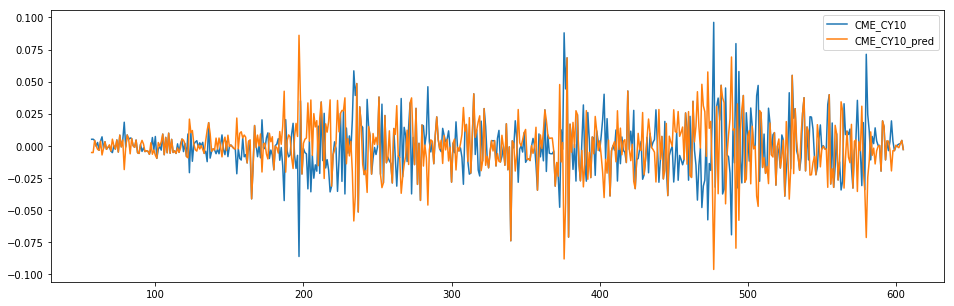

Accuracy Score          0.46083788706739526
F1 Score (avg=macro)    0.6375861760229206
F1 Score (avg=micro)    0.46083788706739526
F1 Score (avg=weighted) 0.4628472543295333
F1 Score (avg=none)     [0.49315068 1.         0.41960784]


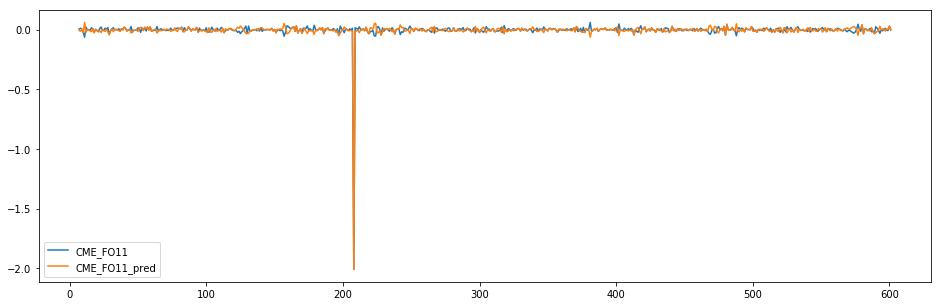

Accuracy Score          0.5226890756302521
F1 Score (avg=macro)    0.679064751502914
F1 Score (avg=micro)    0.5226890756302521
F1 Score (avg=weighted) 0.521320073162577
F1 Score (avg=none)     [0.53896104 1.         0.49823322]


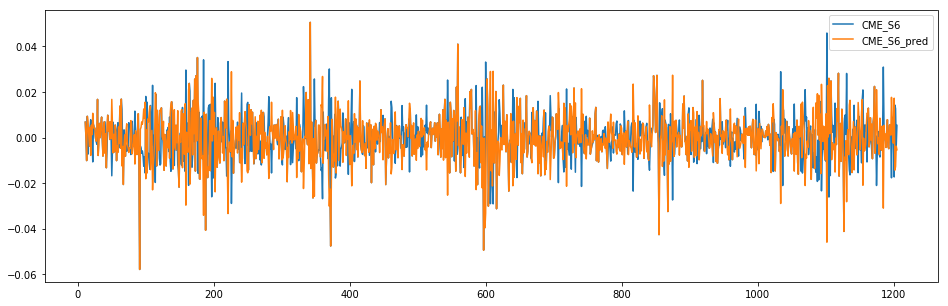

Accuracy Score          0.5087866108786611
F1 Score (avg=macro)    0.6683213250291559
F1 Score (avg=micro)    0.5087866108786611
F1 Score (avg=weighted) 0.5087453303968106
F1 Score (avg=none)     [0.49700086 1.         0.50796312]


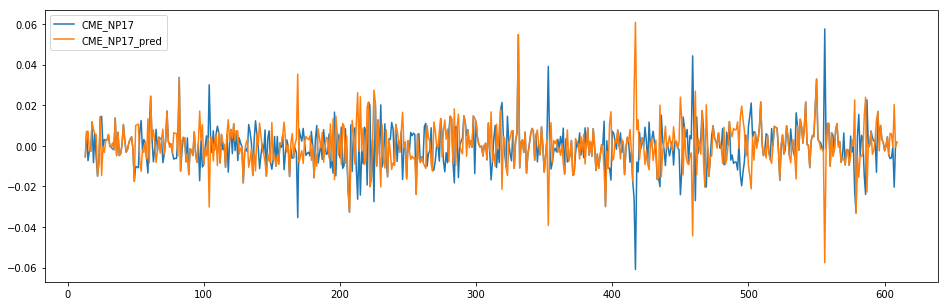

Accuracy Score          0.509212730318258
F1 Score (avg=macro)    0.6685065921875554
F1 Score (avg=micro)    0.509212730318258
F1 Score (avg=weighted) 0.5087680474826353
F1 Score (avg=none)     [0.48506151 1.         0.52045827]


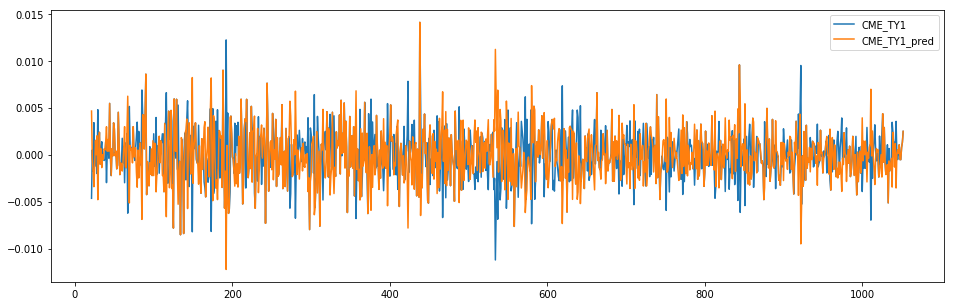

Accuracy Score          0.5145348837209303
F1 Score (avg=macro)    0.6698673151959994
F1 Score (avg=micro)    0.5145348837209303
F1 Score (avg=weighted) 0.5145107018583323
F1 Score (avg=none)     [0.51311953 1.         0.49648241]


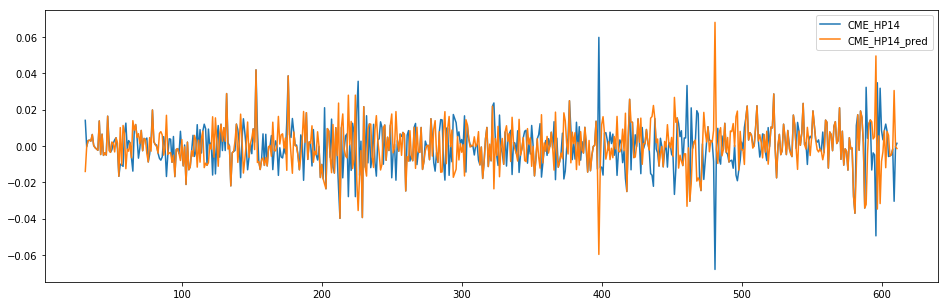

Accuracy Score          0.5301204819277109
F1 Score (avg=macro)    0.684026825408786
F1 Score (avg=micro)    0.5301204819277109
F1 Score (avg=weighted) 0.5301049030724662
F1 Score (avg=none)     [0.52686308 1.         0.52521739]


In [8]:
def get_score(returns, predictions, asset_to_predict, from_, to_, w):
    # accuracy score percentage
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score

    original = returns.iloc[from_+w : to_+w][asset_to_predict]

    df = pd.DataFrame(original)
    df[asset_to_predict+"_pred"] = predictions

    df = np.sign(df)
    y_true = df[asset_to_predict].tolist()
    y_pred = df[asset_to_predict+'_pred'].tolist()

    print("Accuracy Score         ", accuracy_score(y_true, y_pred))
    print("F1 Score (avg=macro)   ", f1_score(y_true, y_pred, average='macro'))
    print("F1 Score (avg=micro)   ", f1_score(y_true, y_pred, average='micro'))
    print("F1 Score (avg=weighted)", f1_score(y_true, y_pred, average='weighted'))
    print("F1 Score (avg=none)    ", f1_score(y_true, y_pred, average=None))
    

def show_rf_result_stats():
    assets_to_predict_num = [504,945,2629,2198,2726,1354]
    
    for key in assets_to_predict_num:
        asset_to_predict = returns.columns[key]
        rf_path = './results/'+asset_to_predict
        df_asset_to_predict = pd.read_csv(rf_path+'_returns.csv')
        pred_compare = np.load(rf_path+'_prediction_values.npy').tolist()
        range_from = np.load(rf_path+'_stats.npy').tolist()[0]
        range_to = np.load(rf_path+'_stats.npy').tolist()[1]
        w = np.load(rf_path+'_stats.npy').tolist()[2]

        draw_predictions(df_asset_to_predict, pred_compare, asset_to_predict, range_from, range_to, w)

        get_score(df_asset_to_predict, pred_compare, asset_to_predict, range_from, range_to, w)

show_rf_result_stats()

In [389]:
'''
TODO

fix the positioning! of current to


'''

'CME_CY10'

504
CME_CY10


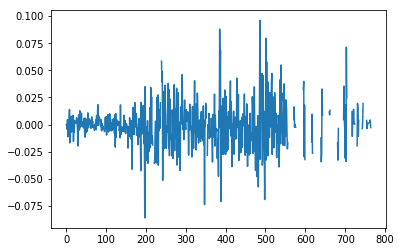

2864
CME_V358


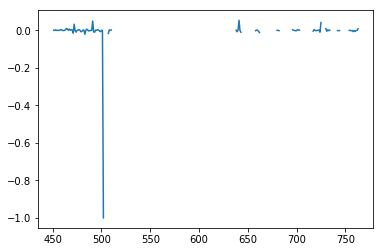

1024
CME_GL8


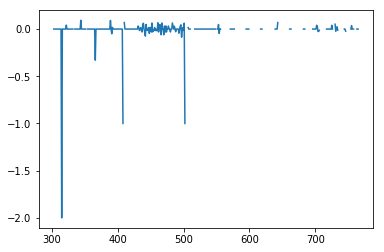

2810
CME_UX3


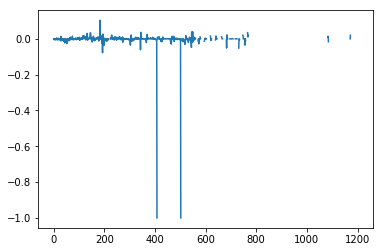

2010
CME_N949


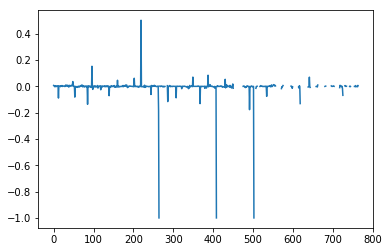

2350
CME_P72


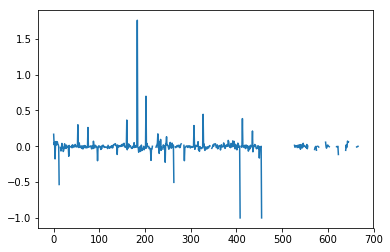

945
CME_FO11


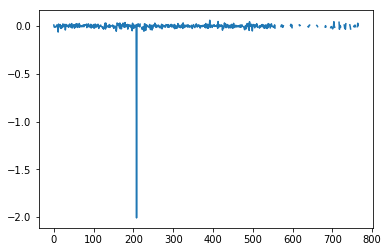

1797
CME_LT20


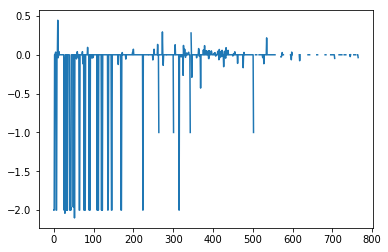

2629
CME_S6


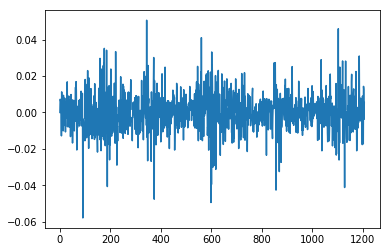

1834
CME_ME5


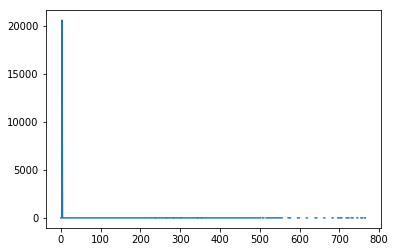

2198
CME_NP17


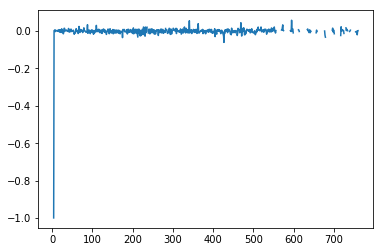

2726
CME_TY1


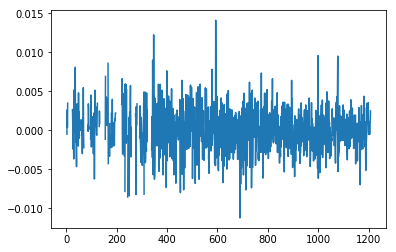

1354
CME_HP14


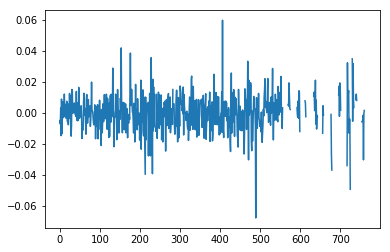

In [466]:

# show normal log returns and nan vals after 2016
for key in keys:
    print(key)
    print(returns.columns[key])
    plt.plot(returns[returns.columns[key]])
    plt.show()

In [ ]:

'''
für alle Clusters
- Target_Asset = jeweils 1 Dominant mit seinen XX Features
- Calc DF mit keinen nans für Target Shape=(550)
start= 1
ende = 550
tin  = 100
1-10,11,12,13,14 ..
-> ersten TIN gehen verloren da keine historischen Daten davor
-> preds = Shape - TIN + 2 um max eine Prediction zu machen, wenn zu viele dann nicht ausreichene features

TODO
- Accurary
- Beauty Plot 
'''